In [6]:
# Download the challenge set files
from pycbc.frame import read_frame
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
%matplotlib inline

'''def get_file(fname):
    url = "https://github.com/gw-odw/odw-2022/raw/main/Tutorials/Day_2/Data/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['challenge1.gwf', 'challenge2.gwf', 'challenge3.gwf']

for fname in files:
    get_file(fname)'''
    

# An example of how to read the data from these files:
file_name = "challenge1.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:CHALLENGE1"

start = 0
end = start + 128

ts = read_frame(file_name, channel_name)

In [7]:
ts.duration

128.0

In [8]:
ts.sample_rate

4096.0

In [9]:
strain = highpass(ts, 15.0)
strain = resample_to_delta_t(strain, 1.0/4096.0)
conditioned = strain.crop(2, 2)

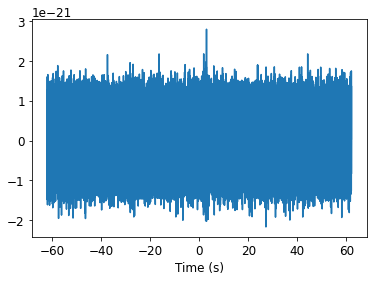

In [10]:
pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [11]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

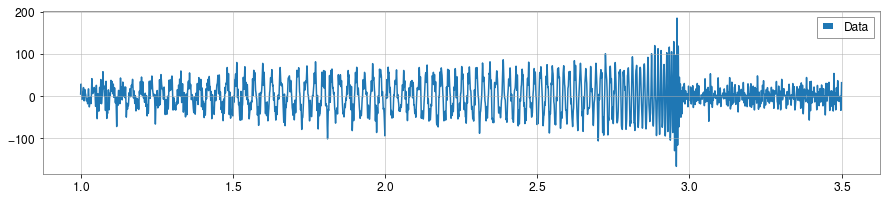

In [31]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
#white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(1,3.5)
#white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
#pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

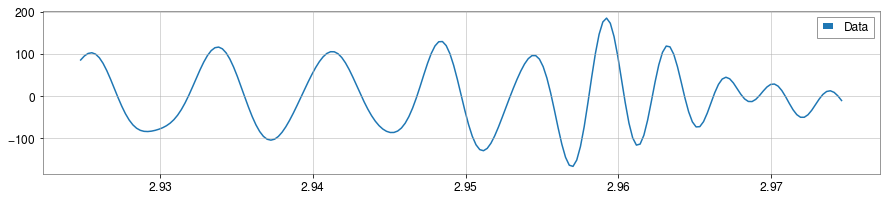

In [37]:
white_data = white_data.time_slice(2.925,2.975)
#white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
#pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

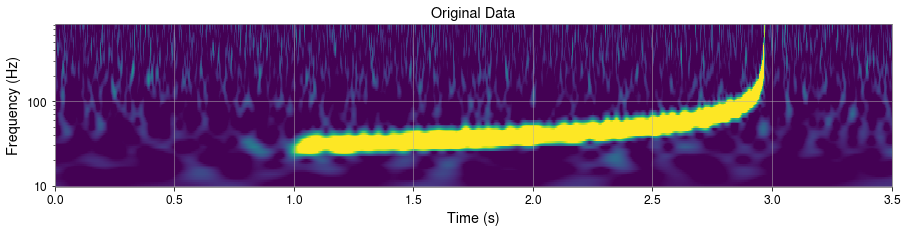

In [35]:
for data, title in [(conditioned, 'Original Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(10, 800))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(0, 3.5)
    pylab.show()

In [38]:
!pwd

/gpfs/glast/Users/burelli/odw-2022/Challenge
